## Importação das bibliotecas

In [31]:
#importar bibliotecas básicas de EDA e Visualização
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
# classe de obtenção dos dados
from Acao import Acao
# bibliotecas de ML
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.graph_objects as go
import os
import joblib

In [32]:
# IMPORTAR PARA IGNORAR OS WARNINGS DO SISTEMA E NÃO POLUIR AS SAÍDAS
#-------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## CONFIGURAÇÕES

O parâmetro X é escolhido conforme o dicionário abaixo, escolha o número conforme o papel desejado para treinamento.



In [33]:
# TICKERS UTILIZADOS
#----------------------------------------
dict_acoes = {
    1: ['BANCO_DO_BRASIL', 'BBAS3.SA'],
    2: ['IBOVESPA', '^BVSP']
}

In [49]:
#------------------------------------
# CONFIGURAÇÕES
#-----------------------------------

X = 1
PAPEL = dict_acoes[X][0]
MODEL_NAME = "StatsForecast AutoARIMA"
MODEL_PATH = "app/models/"
METADATA_PATH = "app/metadata/"
DATA_FINAL = '2026-01-12'

#os.makedirs('../.venv/app/models')
#os.makedirs('../.venv/app/metadata')

In [35]:
# df É O DATAFRAME COM OS DADOS COLETADOS DO PAPEL
#----------------------------------------------------------
papel = dict_acoes[X][1]
acao = Acao(papel)
df = acao.retorna_df('10y', pd.to_datetime(DATA_FINAL))

Retornando os dados do papel ^BVSP, no período de 10y


[*********************100%***********************]  1 of 1 completed


## FUNÇÕES

###  DEFINIR A MÉTRICA DE VALIDAÇÃO DO MODELO

### $$WMAPE$$ sigla para Weighted Mean Absolute Percentage Error (Erro Percentual Absoluto Médio Ponderado), é um indicador que mede a acurácia de previsões (forecasts) de forma ponderada, dando mais importância a itens ou períodos de maior volume ou relevância, o que o torna mais estratégico que o MAPE puro, ajudando a identificar desvios significativos no planejamento de demanda e produção.

In [36]:
def wmape(y_true, y_pred):
  resultado = (np.abs(y_true - y_pred).sum() / np.abs(y_true).sum())
  return resultado

### FUNÇÃO QUE CRIA A TARGET NA TABELA DE PREVISÃO FINAL, PARA CÁLCULO DE ACURÁCIA

In [37]:
# VERIFICAÇÃO DA ACURÁCIA DOS MODELOS ATRAVÉS DA CRIAÇÃO DE UMA VARIÁVEL TARGET
def resultado_target(abertura, fechamento):
    val_ab = abertura.values
    val_fc = fechamento.values
    delta = val_ab - val_fc
    resultado = delta
    for i in range(len(delta)):
        resultado[i] = (2 if delta[i] < 0 else (1 if delta[i] == 0 else 0))
    return resultado

### FUNÇÕES QUE CALCULAM E SALVAM AS PREDIÇÕES DAS EXÓGENAS

In [38]:
# FUNÇÕES QUE PREVEEM AS EXOGENAS
def previsao_maxima(df, h, s):
    df = df.drop(['minima', 'y'], axis=1)
    df = df.rename(columns={'maxima': 'y'})
    limite = df.index[-h]
    treino = df.loc[df.index < limite]
    model = StatsForecast(models=[AutoARIMA(season_length=s)], freq='B', n_jobs=-1)
    model.fit(treino)
    df_pred = model.predict(h=h)
    df_pred = df_pred.rename(columns={'AutoARIMA': 'maxima'})
    joblib.dump(model, f'{MODEL_PATH}model_prev_max_{PAPEL}.pkl')
    return df_pred

def previsao_minima(df, h, s):
    df = df.drop(['maxima', 'y'], axis=1)
    df = df.rename(columns={'minima': 'y'})
    limite = df.index[-h]
    treino = df.loc[df.index < limite]
    model = StatsForecast(models=[AutoARIMA(season_length=s)], freq='B', n_jobs=-1)
    model.fit(treino)
    df_pred = model.predict(h=h)
    df_pred = df_pred.rename(columns={'AutoARIMA': 'minima'})
    joblib.dump(model, f'{MODEL_PATH}model_prev_min_{PAPEL}.pkl')
    return df_pred
    
    
    

## AJUSTE DO DF DO YFINANCE PARA O STATSFORECAST

In [39]:
# ADEQUAR O DATAFRAME DO YFINANCE PARA O PADRÃO DO STATSFORECAST
df_stats = df[['maxima', 'minima', 'fechamento']].resample('B').last().ffill().copy()#preencher dias não presentes com o dado da última amostra, melhora o desempenho do modelo
df_stats = df_stats.dropna()
df_stats = df_stats.reset_index()
df_stats['unique_id'] = 1
df_stats = df_stats.rename(columns={'fechamento':'y', 'Date': 'ds'})
df_stats.tail()

Price,ds,maxima,minima,y,unique_id
2604,2026-01-05,162166.0,160215.0,161870.0,1
2605,2026-01-06,164135.0,161870.0,163664.0,1
2606,2026-01-07,163661.0,161746.0,161975.0,1
2607,2026-01-08,162937.0,161748.0,162937.0,1
2608,2026-01-09,164263.0,162638.0,163370.0,1


## TREINO E TESTE DO AUTOARIMA

In [40]:
h=15 #horizonte de previsão
limite = df.index[-h] #data limite do treino
treino_stats = df_stats.loc[df_stats['ds'] < limite]
teste_stats = df_stats.loc[df_stats['ds'] >= limite]


In [41]:
df_stats

Price,ds,maxima,minima,y,unique_id
0,2016-01-12,40261.0,39426.0,39514.0,1
1,2016-01-13,40050.0,38822.0,38944.0,1
2,2016-01-14,39502.0,38459.0,39500.0,1
3,2016-01-15,39494.0,37986.0,38569.0,1
4,2016-01-18,38633.0,37937.0,37937.0,1
...,...,...,...,...,...
2604,2026-01-05,162166.0,160215.0,161870.0,1
2605,2026-01-06,164135.0,161870.0,163664.0,1
2606,2026-01-07,163661.0,161746.0,161975.0,1
2607,2026-01-08,162937.0,161748.0,162937.0,1


In [42]:
#CRIAÇÃO DO DF COM AS EXOGENAS PREVISTAS

maxima_pred = previsao_maxima(df_stats, h, 28)
minima_pred = previsao_minima(df_stats, h, 28)

df_pred_exog = maxima_pred.merge(minima_pred[['ds', 'minima']], on='ds', how='left')

df_pred_exog

,unique_id,ds,maxima,minima
0,1,2025-12-22,159746.411351,158030.536656
1,1,2025-12-23,159792.416364,158076.228904
2,1,2025-12-24,159838.421378,158121.921153
3,1,2025-12-25,159884.426392,158167.613401
4,1,2025-12-26,159930.431405,158213.305649
5,1,2025-12-29,159976.436419,158258.997897
6,1,2025-12-30,160022.441433,158304.690146
7,1,2025-12-31,160068.446446,158350.382394
8,1,2026-01-01,160114.451460,158396.074642
9,1,2026-01-02,160160.456474,158441.766890


In [45]:
model_ar = StatsForecast(models=[AutoARIMA(season_length=28)], freq='B', n_jobs=-1)

model_ar.fit(treino_stats)

df_pred_ar = model_ar.predict(h=h, X_df = df_pred_exog)

joblib.dump(model_ar, f'{MODEL_PATH}model_{PAPEL}.pkl')

with open(f'{METADATA_PATH}meta.txt', 'w', encoding='utf-8') as f:
    f.write(f'model_name={MODEL_NAME}\n')
    f.write(f'data_treino={limite}\n')
    f.write(f'data_teste={DATA_FINAL}\n')
    f.write(f'papel=IBOVESPA\n')

df_pred_ar.tail()

,unique_id,ds,AutoARIMA
10,1,2025-12-30,159383.924600
11,1,2025-12-31,159429.758952
12,1,2026-01-01,159475.593303
13,1,2026-01-02,159521.427655
14,1,2026-01-05,159567.262006


In [46]:
abertura = df.loc[df.index >= limite]['abertura'].values
df_pred_ar = df_pred_ar.merge(df_stats[['ds','y']], on='ds', how='left')
df_pred_ar['abertura'] = abertura
df_pred_ar.head()

,unique_id,ds,AutoARIMA,y,abertura
0,1,2025-12-16,158877.356602,158578.0,162482.0
1,1,2025-12-17,158971.415435,157327.0,158578.0
2,1,2025-12-18,159017.249787,157923.0,157327.0
3,1,2025-12-19,159063.084138,158473.0,157928.0
4,1,2025-12-22,159108.918490,158142.0,158480.0


Precisao modelo: 66.67%
WMAPE modelo: 0.81%


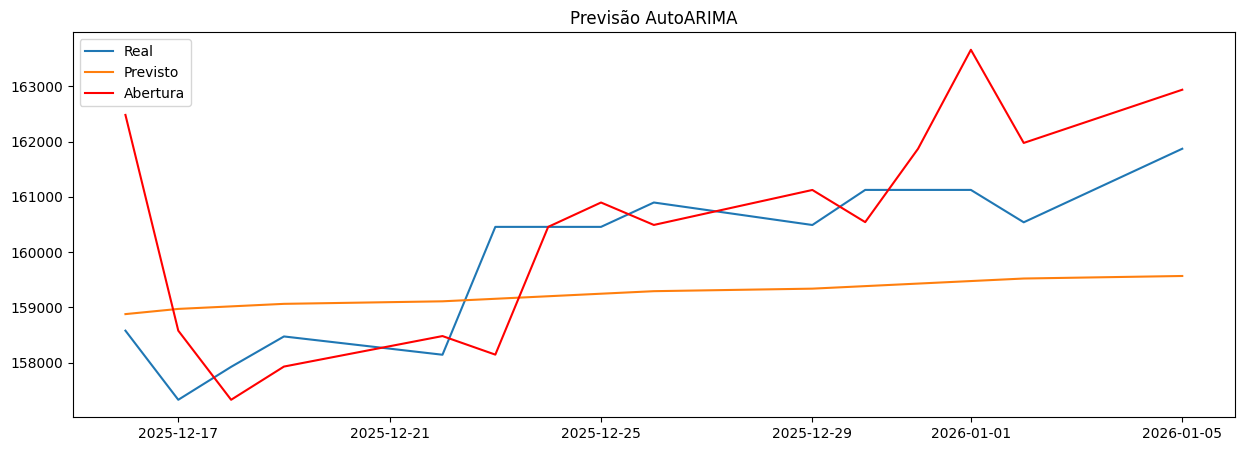

In [47]:
df_pred_ar['target'] = resultado_target(df_pred_ar['abertura'], df_pred_ar['y'])
df_pred_ar['target_arima'] = resultado_target(df_pred_ar['abertura'], df_pred_ar['AutoARIMA'])
a = wmape(df_pred_ar['y'].values, df_pred_ar['AutoARIMA'].values)
precisao = accuracy_score(df_pred_ar['target'], df_pred_ar['target_arima'])

print(f'Precisao modelo: {precisao:.2%}')
print(f'WMAPE modelo: {a:.2%}')

# PLOT DO GRÁFICO
# Comparar com o real
#-----------------------------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(df_pred_ar['ds'], df_pred_ar['y'], label='Real')
plt.plot(df_pred_ar['ds'], df_pred_ar['AutoARIMA'], label='Previsto')
plt.plot(df_pred_ar['ds'], df_pred_ar['abertura'], label='Abertura', color='r')
plt.legend()
plt.title('Previsão AutoARIMA')
plt.show()

In [48]:
lista_arima = [
                'p Ordem AR (autoregressiva): ',
                'q Ordem MA (média móvel): ',
                'P Ordem AR sazonal: ',
                'Q Ordem MA sazonal: ',
                'm Período sazonal: ',
                'd Diferença não sazonal: ',
                'D Diferença sazonal: '
               ]
result=model_ar.fitted_[0,0].model_
for i in range(7):
    print(f'{lista_arima[i]} {result['arma'][i]}')

p Ordem AR (autoregressiva):  0
q Ordem MA (média móvel):  1
P Ordem AR sazonal:  0
Q Ordem MA sazonal:  0
m Período sazonal:  1
d Diferença não sazonal:  0
D Diferença sazonal:  0
